 # Lab:  Transfer Learning with a Pre-Trained Deep Neural Network

As we discussed earlier, state-of-the-art neural networks involve millions of parameters that are prohibitively difficult to train from scratch.  In this lab, we will illustrate a powerful technique called *fine-tuning* where we start with a large pre-trained network and then re-train only the final layers to adapt to a new task.  The method is also called *transfer learning* and can produce excellent results on very small datasets with very little computational time.  

This lab is based partially on this
[excellent blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).  In performing the lab, you will learn to:
* Build a custom image dataset
* Fine tune the final layers of an existing deep neural network for a new classification task.
* Load images with a `DataGenerator`.

The lab has two versions:
* *CPU version*:  In this version, you use lower resolution images so that the lab can be performed on your laptop.  The resulting accuracy is lower.  The code will also take considerable time to execute.
* *GPU version*:  This version uses higher resolution images but requires a GPU instance. See the [notes](../GCP/getting_started.md) on setting up a GPU instance on Google Cloud Platform.  The GPU training is much faster (< 1 minute).  

**MS students must complete the GPU version** of this lab.

## Create a Dataset

In this example, we will try to develop a classifier that can discriminate between two classes:  `cars` and `bicycles`.  One could imagine this type of classifier would be useful in vehicle vision systems.   The first task is to build a dataset.  

TODO:  Create training and test datasets with:
* 1000 training images of cars
* 1000 training images of bicylces
* 300 test images of cars
* 300 test images of bicylces
* The images don't need to be the same size.  But, you can reduce the resolution if you need to save disk space.

The images should be organized in the following directory structure:

    ./train
        /car
           car_0000.jpg
           car_0001.jpg
           ...
           car_0999.jpg
        /bicycle
           bicycle_0000.jpg
           bicycle_0001.jpg
           ...
           bicycle_0999.jpg
    ./test
        /car
           car_1001.jpg
           car_1001.jpg
           ...
           car_1299.jpg
        /bicycle
           bicycle_1000.jpg
           bicycle_1001.jpg
           ...
           bicycle_1299.jpg
           
The naming of the files within the directories does not matter.  The `ImageDataGenerator` class below will find the filenames.  Just make sure there are the correct number of files in each directory.
           
A nice automated way of building such a dataset if through the [FlickrAPI](demo2_flickr_images.ipynb).  Remember that if you run the FlickrAPI twice, it may collect the same images.  So, you need to run it once and split the images into training and test directories.         
        

## Loading a Pre-Trained Deep Network

We follow the [VGG16 demo](./demo3_vgg16.ipynb) to load a pre-trained deep VGG16 network.  First, run a command to verify your instance is connected to a GPU.

In [1]:
# TODO
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10550271530009638212
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18154950709580935467
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6716559370144539522
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11276946637
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16483989929269937475
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


Now load the appropriate tensorflow packages.

In [2]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense


We also load some standard packages.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Clear the Keras session.

In [4]:
# TODO
import tensorflow.keras.backend as K
K.clear_session()

Set the dimensions of the input image.  The sizes below would work on a GPU machine.  But, if you have a CPU image, you can use a smaller image size, like `64 x 64`.

In [5]:
# TODO:  Set to smaller values if you are using a CPU.  
# Otherwise, do not change this code.
nrow = 150
ncol = 150

Now we follow the [VGG16 demo](./vgg16.ipynb) and load the deep VGG16 network.  Alternatively, you can use any other pre-trained model in keras.  When using the `applications.VGG16` method you will need to:
* Set `include_top=False` to not include the top layer
* Set the `image_shape` based on the above dimensions.  Remember, `image_shape` should be `height x width x 3` since the images are color.

In [6]:
# TODO:  Load the VGG16 network
input_shape = (nrow, ncol, 3)
base_model = applications.VGG16(weights='imagenet', include_top = False, input_shape = input_shape)

Instructions for updating:
Colocations handled automatically by placer.


To create now new model, we create a Sequential model.  Then, loop over the layers in `base_model.layers` and add each layer to the new model.

In [7]:
# Create a new model
model = Sequential()
# TODO:  Loop over base_model.layers and add each layer to model
for layer in base_model.layers:
    model.add(layer)

Next, loop through the layers in `model`, and freeze each layer by setting `layer.trainable = False`.  This way, you will not have to *re-train* any of the existing layers.

In [8]:
# TODO
for layer in model.layers:
    layer.trainable = False

Now, add the following layers to `model`:
* A `Flatten()` layer which reshapes the outputs to a single channel.
* A fully-connected layer with 256 output units and `relu` activation
* A `Dropout(0.5)` layer.
* A final fully-connected layer.  Since this is a binary classification, there should be one output and `sigmoid` activation.

In [9]:
# TODO
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Print the model summary.  This will display the number of trainable parameters vs. the non-trainable parameters.

In [10]:
# TODO
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

## Using Generators to Load Data

Up to now, the training data has been represented in a large matrix.  This is not possible for image data when the datasets are very large.  For these applications, the `keras` package provides a `ImageDataGenerator` class that can fetch images on the fly from a directory of images.  Using multi-threading, training can be performed on one mini-batch while the image reader can read files for the next mini-batch. The code below creates an `ImageDataGenerator` for the training data.  In addition to the reading the files, the `ImageDataGenerator` creates random deformations of the image to expand the total dataset size.  When the training data is limited, using data augmentation is very important.

In [11]:
train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.


Now, create a similar `test_generator` for the test data.

In [12]:
# TODO
test_data_dir = './test'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 600 images belonging to 2 classes.


The following function displays images that will be useful below.

In [13]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])

To see how the `train_generator` works, use the `train_generator.next()` method to get a minibatch of data `X,y`.  Display the first 8 images in this mini-batch and label the image with the class label.  You should see that bicycles have `y=0` and cars have `y=1`.

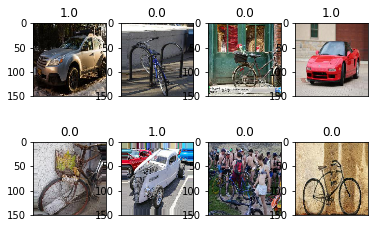

In [14]:
# TODO
X,y = train_generator.next()
for i in range(8):
    plt.subplot(2,4,i+1)
    disp_image(X[i,:])
    plt.title(y[i])

## Train the Model

Compile the model.  Select the correct `loss` function, `optimizer` and `metrics`.  Remember that we are performing binary classification.

In [15]:
# TODO.
from tensorflow.keras import optimizers

opt = optimizers.Adam(lr=0.001) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer = opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

When using an `ImageDataGenerator`, we have to set two parameters manually:
* `steps_per_epoch =  training data size // batch_size`
* `validation_steps =  test data size // batch_size`

We can obtain the training and test data size from `train_generator.n` and `test_generator.n`, respectively.

In [16]:
# TODO
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

Now, we run the fit.  If you are using a CPU on a regular laptop, each epoch will take about 3-4 minutes, so you should be able to finish 5 epochs or so within 20 minutes.  On a reasonable GPU, even with the larger images, it will take about 10 seconds per epoch.
* If you use `(nrow,ncol) = (64,64)` images, you should get around 90% accuracy after 5 epochs.
* If you use `(nrow,ncol) = (150,150)` images, you should get around 96% accuracy after 5 epochs.  But, this will need a GPU.

You will get full credit for either version.  With more epochs, you may get slightly higher, but you will have to play with the damping.

Remember to record the history of the fit, so that you can plot the training and validation accuracy curve.

In [17]:
nepochs = 5  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
63/63 [==============================] - 38s 599ms/step - loss: 0.2616 - acc: 0.9020 - val_loss: 0.0900 - val_acc: 0.9650
Epoch 2/5
63/63 [==============================] - 22s 346ms/step - loss: 0.1177 - acc: 0.9585 - val_loss: 0.0829 - val_acc: 0.9633
Epoch 3/5
63/63 [==============================] - 22s 350ms/step - loss: 0.0981 - acc: 0.9625 - val_loss: 0.0748 - val_acc: 0.9650
Epoch 4/5
63/63 [==============================] - 22s 348ms/step - loss: 0.0831 - acc: 0.9690 - val_loss: 0.0784 - val_acc: 0.9733
Epoch 5/5
63/63 [==============================] - 22s 351ms/step - loss: 0.0726 - acc: 0.9740 - val_loss: 0.1322 - val_acc: 0.9450


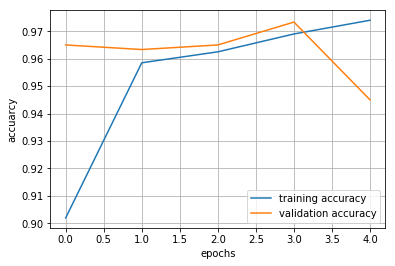

In [18]:
# Plot the training accuracy and validation accuracy curves on the same figure.

# TO DO
tr_accuracy = hist.history['acc']
val_accuracy = hist.history['val_acc']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

## Plotting the Error Images

Now try to plot some images that were in error:

*  Generate a mini-batch `Xts,yts` from the `test_generator.next()` method
*  Get the class probabilities using the `model.predict( )` method and compute predicted labels `yhat`.
*  Get the images where `yts[i] ~= yhat[i]`.
*  If you did not get any prediction error in one minibatch, run it multiple times.
*  After you a get a few error images (say 4-8), plot the error images with the true labels and class probabilities predicted by the classifie

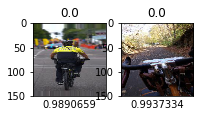

In [44]:
# TO 
Xts,yts = test_generator.next()
preds = model.predict(Xts).flatten()
yhat = np.round(preds).flatten()
index = np.where(yhat != yts)[0]
for i,image in enumerate(Xts[np.where(yhat != yts)]):
    plt.subplot(2,4,i+1)
    disp_image(image)
    plt.title(yts[index[i]])
    plt.xlabel(preds[index[i]])
    